In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


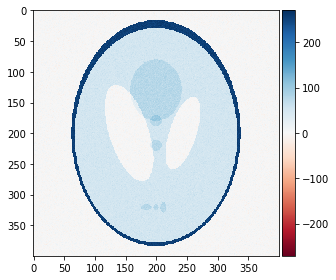

In [2]:
import skimage as sk 
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import data_dir
from skimage.util import img_as_ubyte
from skimage import io
from skimage.util import random_noise

data_dir = '/content/drive/MyDrive/I&I MASTER /Computer Vision'

I = img_as_ubyte(io.imread(os.path.join(data_dir, "phantom.png"),as_gray=True))

# Add gaussian noise with mean 0 and variance sigma: 
sigma = 5
In = I + sigma*np.random.normal(0, 1, (I.shape[0],I.shape[1]))

sk.io.imshow(In)

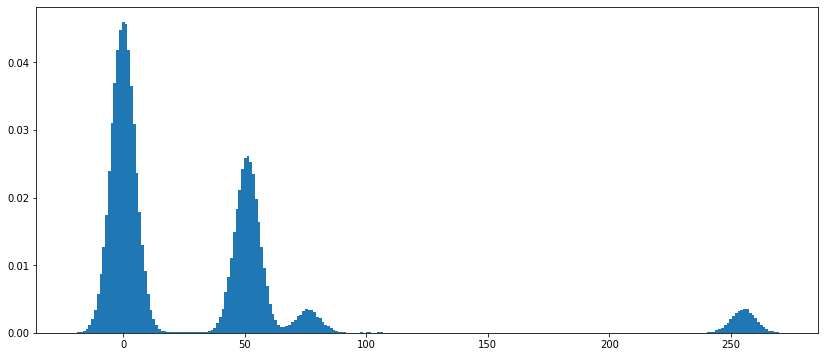

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# reshape training image as 1d array:
v_I = In.reshape(In.shape[0]*In.shape[1],1)

fig = plt.figure(figsize=(14, 6))
plt.hist(v_I,bins=256,density=True)
plt.show()

In [5]:
np.unique(v_I)

array([-21.10745838, -20.3614468 , -19.496466  , ..., 270.32164239,
       270.45330085, 271.00788201])

# Kmeans clustering 

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


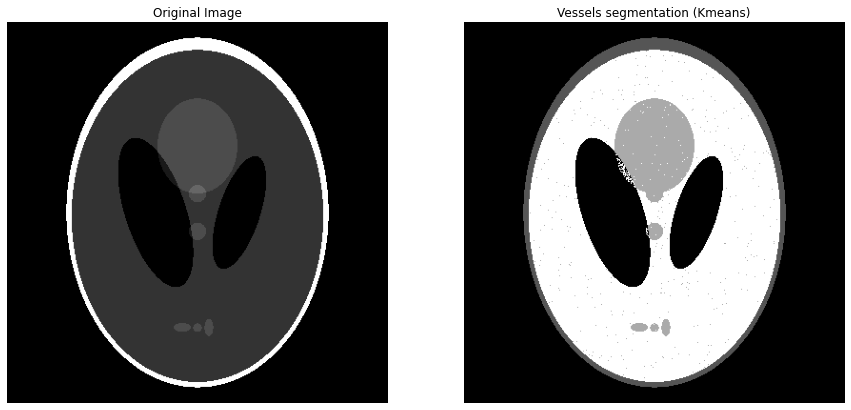

In [16]:
from sklearn.cluster import KMeans

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=4, random_state=0).fit(v_I)

# Apply to predict test image:

v_kmeans = kmeans.predict(v_I)
I_kmeans = np.array(v_kmeans).reshape(I.shape[0],I.shape[1]).astype(np.uint8)# Shape back result as image 


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Kmeans)')
ax2.set_axis_off()

plt.show()

In [7]:
kmeans.cluster_centers_

array([[4.30366632e-02],
       [2.55097983e+02],
       [7.60736288e+01],
       [5.08910843e+01]])

In [8]:
v_kmeans = kmeans.predict(v_I)
np.unique(v_kmeans)

array([0, 1, 2, 3], dtype=int32)

# GMM model selection for segmentation:

In [25]:
from skimage import io, exposure  
from sklearn.cluster import KMeans, AgglomerativeClustering
from skimage.measure import label
from skimage.transform import resize
from skimage.color import label2rgb, rgb2gray
import numpy as np
import skimage as sk 
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import mixture

#calcula el BIC per trobar el número de gaussianes òptim
NMAX = 10
bic = []
aic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(v_I)
    bic.append(gmm.bic(v_I)) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

[1735123.7580838897]
[1735123.7580838897, 1546239.041329025]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578, 1280586.8340901653]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578, 1280586.8340901653, 1281483.2231950185]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578, 1280586.8340901653, 1281483.2231950185, 1281661.4114954162]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578, 1280586.8340901653, 1281483.2231950185, 1281661.4114954162, 1281935.9435559623]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578, 1280586.8340901653, 1281483.2231950185, 1281661.4114954162, 1281935.9435559623, 1281897.109955592]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578, 1280586.8340901653, 1281483.2231950185, 1281661.4114954162, 1281935.9435559623, 1281897.109955592, 1281947.8648884061]
[1735123.7580838897, 1546239.041329025, 1312903.9112092578, 1280586.8340901653, 1281483.2231950185, 1

In [27]:
gmmw = mixture.GaussianMixture(n_components=idx_winner+1).fit(v_I)
v_agg = gmmw.fit_predict(v_I)
I_gmm = np.array(v_agg).reshape(I.shape[0],I.shape[1])# Shape back result as image

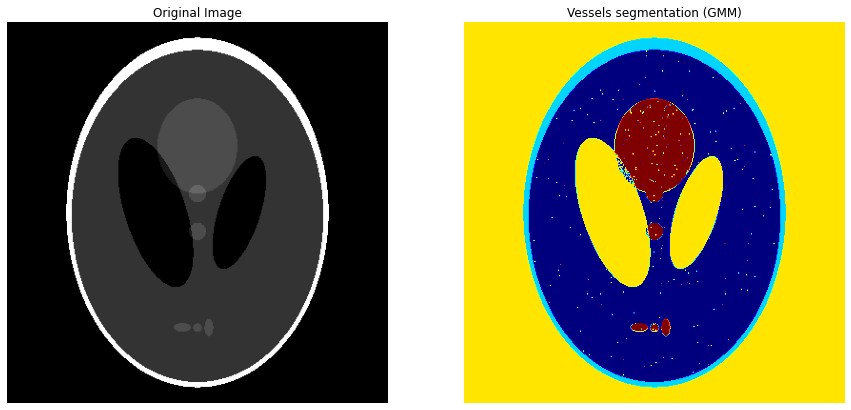

In [28]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_gmm, cmap=plt.cm.jet)
ax2.set_title('Vessels segmentation (GMM)')
ax2.set_axis_off()

plt.show()